# LSTM Neural Network Model for COVID-19 Forecasting in Ontario

Modelling and forecasting COVID-19 cases, deaths, and recoveries in Ontario as a time series using an LSTM (Long Short Term Memory) Neural Network.

The data sets are from the Carleton University AI Kaggle Competition (October 2020) with additional data from a dataset provided by ESRI Canada to provide additional information related to hospitalizations and ICU admissions. The ESRI data can be found at the following link:
https://resources-covid19canada.hub.arcgis.com/datasets/provincial-daily-totals

The LSTM implementation for this project is heavily based on TensorFlow's tutorial on Time Series, and is not my original work. The tutorial and code can be found at:
https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

import IPython
import IPython.display

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Reshape

Get the data (both the competition data and the ESRI data for ICU and hospitalizations)

In [2]:
df = pd.read_csv('Data/train.csv')
esri_df = pd.read_csv('Data/Provincial_Daily_Totals.csv')

## 1) Data Cleaning

Clean the competition data

In [3]:
# Change date to datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Convert dates to the day of the year
df['Day_of_Year'] = df['Date'].apply(lambda x: x.dayofyear)

# Day of the week
df["Day_of_Week"] = df["Date"].apply(lambda x: x.dayofweek)

# Drop some of the columns
df.drop(columns=['Id', 'Lat', 'Long', 'Testing_Info'], inplace=True)

# Drop data for repatriated Canadians repatriated data
df.drop(df[df['Province'] == 'Repatriated'].index, inplace=True)

# Fill N/A values to 0
df = df.fillna(0)

# Set index to Date
df.set_index('Date', inplace=True)

Plot the confirmed number of cases for all provinces over time

Text(0, 0.5, 'Number of Deaths')

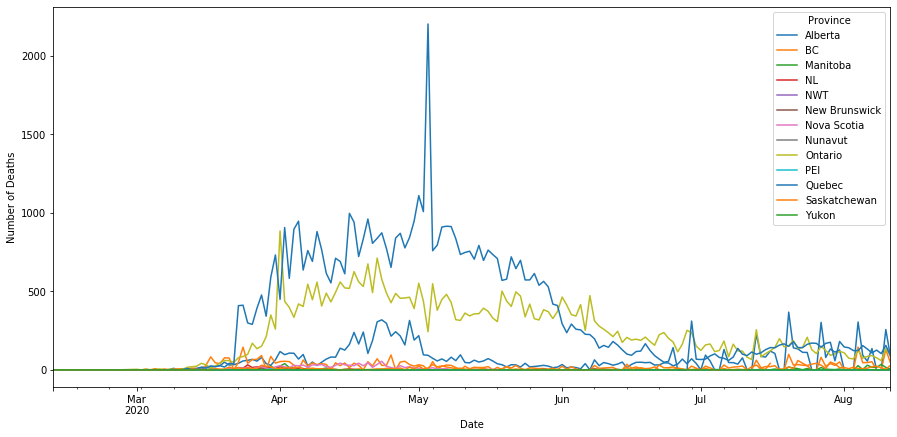

In [4]:
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['Date','Province']).mean()['# Confirmed_Cases'].unstack().plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Deaths')

Clean the ESRI data

In [5]:
# Remove the data for Canada and Repatriated Canadians
esri_df.drop(esri_df[esri_df['Abbreviation'].isin(['CA', 'RC'])].index, inplace=True)

# Change the province names to be consistent with the Competition dataset
esri_df.loc[esri_df['Province'] == 'ALBERTA', ['Province']] = 'Alberta'
esri_df.loc[esri_df['Province'] == 'BRITISH COLUMBIA', ['Province']] = 'BC'
esri_df.loc[esri_df['Province'] == 'MANITOBA', ['Province']] = 'Manitoba'
esri_df.loc[esri_df['Province'] == 'NEW BRUNSWICK', ['Province']] = 'New Brunswick'
esri_df.loc[esri_df['Province'] == 'NEWFOUNDLAND AND LABRADOR', ['Province']] = 'NL'
esri_df.loc[esri_df['Province'] == 'NORTHWEST TERRITORIES', ['Province']] = 'NWT'
esri_df.loc[esri_df['Province'] == 'NOVA SCOTIA', ['Province']] = 'Nova Scotia'
esri_df.loc[esri_df['Province'] == 'NUNAVUT', ['Province']] = 'Nunavut'
esri_df.loc[esri_df['Province'] == 'ONTARIO', ['Province']] = 'Ontario'
esri_df.loc[esri_df['Province'] == 'PRINCE EDWARD ISLAND', ['Province']] = 'PEI'
esri_df.loc[esri_df['Province'] == 'QUEBEC', ['Province']] = 'Quebec'
esri_df.loc[esri_df['Province'] == 'SASKATCHEWAN', ['Province']] = 'Saskatchewan'
esri_df.loc[esri_df['Province'] == 'YUKON', ['Province']] = 'Yukon'

# Fill the N/A values
esri_df = esri_df.fillna(0)

# Change the Date to the Day of the Year
esri_df['Date'] = pd.to_datetime(esri_df['SummaryDate'])
esri_df['Day_of_Year'] = esri_df['Date'].apply(lambda x: x.dayofyear)

# Drop some of the unecessary columns
esri_df.drop(columns=['OBJECTID', 'SummaryDate', 'Date', 'DailyTested', 'DailyTotals', 'DailyRecovered', 'DailyDeaths', 'Abbreviation', 'TotalCases', 'TotalRecovered', 'TotalDeaths', 'TotalTested'], inplace=True)

## 2) Data Preparation

Merge the ICU and Hospitalization data into the competition data

In [6]:
df = df.merge(esri_df, on=['Province', 'Day_of_Year'])

Get the data for Ontario

In [7]:
df = df[df['Province'] == 'Ontario']
df.drop(columns=['Province', 'Population'], inplace=True)
df.set_index('Day_of_Year', inplace=True)

Get the number of features and sort the column names into a dictionary for later use

In [8]:
num_features = df.shape[1]
column_indices = {name: i for i, name in enumerate(df.columns)}

Split into train, validation, and test sets (70%, 20%, 10%)

In [9]:
n = df.shape[0]
train_df = df[0:round(n*0.7)]
valid_df = df[round(n*0.7):round(n*0.9)]
test_df = df[round(n*0.9):]

Normalize the data

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df-train_mean)/train_std
valid_df = (valid_df-train_mean)/train_std
test_df = (test_df-train_mean)/train_std

## 3) Creating Windows

The following code is all from the TensorFlow tutorial.

They implement a **WindowGenerator** class which represents a time window over which predictions can be made, and the networks can be trained.

The windows represent 

1) The number of time steps for each of the input and label windows

2) The time offset between them

3) The features that are used as inputs, labels, or both

For more details, and for the original code, please see https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing

In [11]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, valid_df=valid_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.valid_df = valid_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

The function to split a time window into a window of features and a window of labels

In [12]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Define a plot function for the windows

In [13]:
def plot(self, model=None, plot_col='# Deaths', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [days]')

WindowGenerator.plot = plot

Define a function to take a DataFrame and convert it into a tf.data.Dataset object of the
form (input_window, label_window) 

In [14]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=16,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

Add properties to the WindowGenerator objects to access the training, validation, and test sets

In [15]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.valid_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## 4) Model Setup

These models forecast all the features simultaneaously without any autoregressive behaviour. (i.e. using the previous predictions as inputs for the subsequent prediction)

The models forecast 7 days into the future based on data from the past 10 days.

Create the Window object for the output

In [16]:
num_input_days = 10
num_forecast_days = 7

window = WindowGenerator(input_width=num_input_days,
                               label_width=num_forecast_days,
                               shift=num_forecast_days)
window

Total window size: 17
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10 11 12 13 14 15 16]
Label column name(s): None

Plot the number of deaths in the window for some sample sections of the data

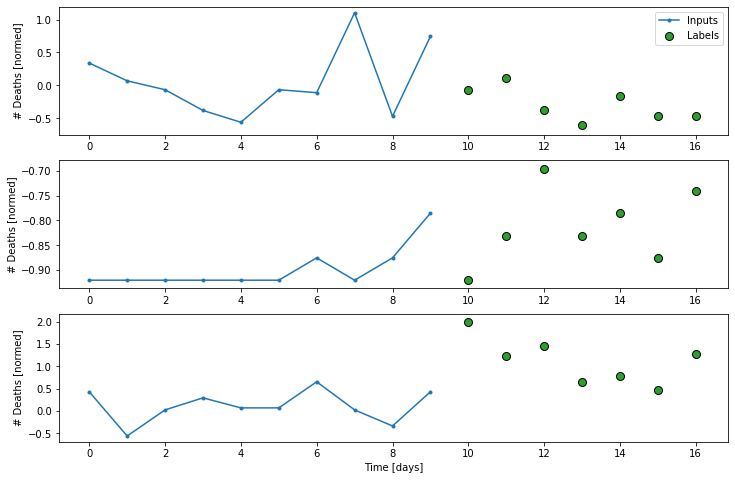

In [17]:
# Stack three figures, each the length of the window, and each giving a slice of the data:
example_window = tf.stack([np.array(train_df[:window.total_window_size]),
                           np.array(train_df[50:50+window.total_window_size]),
                           np.array(train_df[100:100+window.total_window_size])])
example_inputs, example_labels = window.split_window(example_window)

window.plot(plot_col='# Deaths')

Create a function to compile and fit all the models (from TensorFlow tutorial)

In [18]:
# Set a maximum of epochs
MAX_EPOCHS = 50

# Define a function to compile and fit the models
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Create dictionaries to store the performance measurements for the models

In [19]:
val_performance = {}
performance = {}

## 5) Model Creation

### a) Baseline Model

Assume that next values are equal to the values just seen.

In [20]:
# From the TensorFlow tutorial

# define the baseline model class
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, num_forecast_days, 1])

# build the model
baseline = MultiStepLastBaseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

# evaluate the performance on the validation and test sets
val_performance['Baseline'] = baseline.evaluate(window.val)
performance['Baseline'] = baseline.evaluate(window.test, verbose=0)

2/2 [==============================] - 0s 17ms/step - loss: 0.4966 - mean_absolute_error: 0.3662


Plot the number of deaths predicted by the model

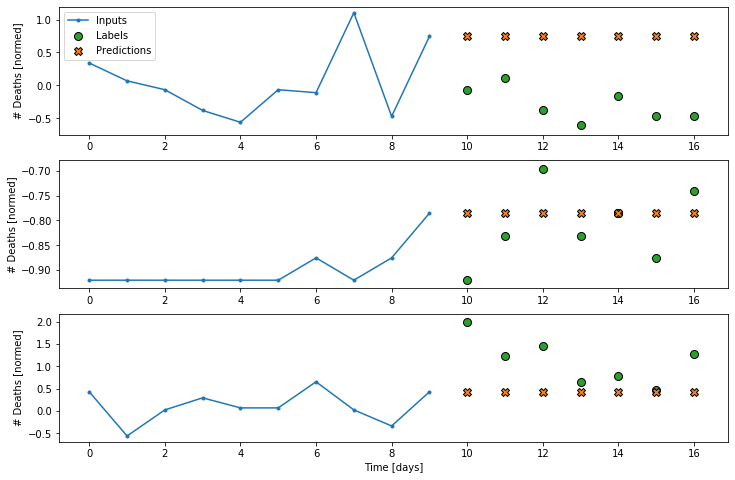

In [21]:
window.plot(baseline, plot_col='# Deaths')

### b) Regular Neural Network

In [22]:
nn_model = Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    Dense(64, activation='relu'),
    # Shape => [batch, 1, num_forecast_days*features]
    Dense(num_forecast_days*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, num_forecast_days, features]
    Reshape([num_forecast_days, num_features])
])

history = compile_and_fit(nn_model, window)

IPython.display.clear_output()

val_performance['NN'] = nn_model.evaluate(window.val)
performance['NN'] = nn_model.evaluate(window.test, verbose=0)

2/2 [==============================] - 0s 12ms/step - loss: 0.4345 - mean_absolute_error: 0.4269


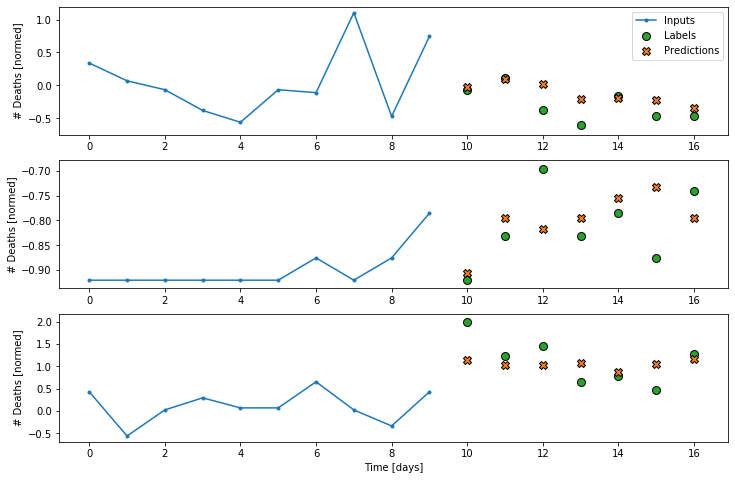

In [23]:
window.plot(nn_model, plot_col='# Deaths')

### c) LSTM Neural Network

In [24]:
lstm_model = Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    LSTM(64, return_sequences=False),
    # Shape => [batch, num_forecast_days*features]
    Dense(num_forecast_days*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, num_forecast_days, features]
    Reshape([num_forecast_days, num_features])
])

history = compile_and_fit(lstm_model, window)

IPython.display.clear_output()

val_performance['LSTM'] = lstm_model.evaluate(window.val)
performance['LSTM'] = lstm_model.evaluate(window.test, verbose=0)

2/2 [==============================] - 0s 6ms/step - loss: 0.8076 - mean_absolute_error: 0.5628


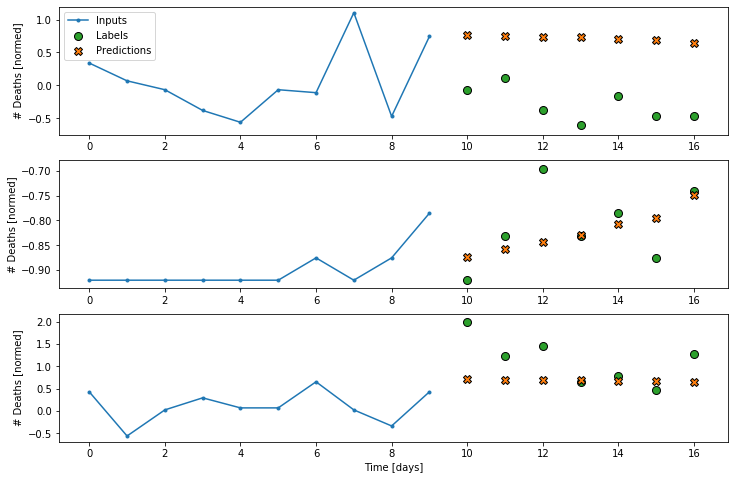

In [25]:
window.plot(lstm_model, plot_col='# Deaths')

## 6) Comparison of the models

From TensorFlow tutorial

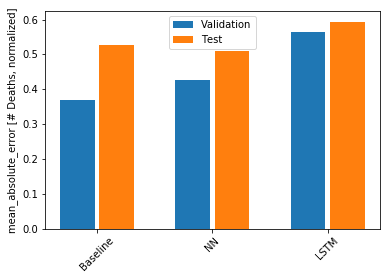

In [26]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [# Deaths, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [27]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.5267
NN          : 0.5089
LSTM        : 0.5943
